-----
# CNN - Convolutional Neural Network Model
-----

### Summary:
Creating a basic CNN architecture to see what features are learned for the MNIST Sign Language Dataset.

### Data Overview:
- **Dataset**: MNIST Sign Language Dataset
- **Number of Samples**: Approximately 1400 images per character
- **Image Dimensions**: Each image consists of 784 pixel values (28x28 pixels flattened into a 1D array)

### Notebook Overview:
- **Data Loading**:
   - Load the MNIST Sign Language dataset.
   - Split the data into training and validation sets.

- **Defining the CNN**:
   - Define input layers
   - Define hidden(convoluted) layers
   - Define output layers
   - Define and visualise the CNN model

- **Training my CNN**:
   - Compile the model.
   - Train the model.

- **Model Interpretability**:
   - Learning what CNN has learnt by inspecting the weights(kernels) and feature maps.

- **Model Evaluation**:
   - Assess the accuracy of the model on the validation dataset.
   - Analyse the model's performance using a confusion matrix and visualise misclassifications.

## Set Up
---

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import seaborn as sns
import joblib
import math


In [2]:
# Set random seeds for reproducibility
tf.random.set_seed(1)
np.random.seed(1)

## Data Loading
----

In [3]:
X  = joblib.load( '../../data/my_data/X.pkl' )
y = joblib.load( '../../data/my_data/y.pkl' )

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, stratify = y, random_state=1)

In [5]:
# Checking shape of data
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'y_val shape: {y_val.shape}')

X_train shape: (27701, 784)
y_train shape: (27701,)
X_val shape: (6926, 784)
y_val shape: (6926,)


## Utility Functions
---

In [6]:
alphabet = ['a','b','c','d','e','f','g','h','i','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y']

In [7]:
unique_values, value_counts = np.unique(y, return_counts=True)

In [8]:
def inspect_weights(model, layer_name):
  '''
    Overview:
    To get weights from a given layer.

    Arguments:
        - model: CNN model to inspect
        - layer_name: name of layer to access weights

    Output:
        - kernels (weights) as a 3x3 image
  '''
  layer = model.get_layer(layer_name)
  weights, baises = layer.get_weights()

  num_filters = weights.shape[-1]
  rows = math.ceil(num_filters/4)

  fig, axes = plt.subplots(rows,4,figsize=(20,4*rows))

  for i, ax in enumerate(axes.flatten()):
      if i < num_filters:
          ax.imshow(weights[:, :, 0, i], cmap='gray_r')
          ax.set_title(f'Kernel {i+1}', fontsize=20)
          ax.set_xticks([])
          ax.set_yticks([])
      else:
          fig.delaxes(ax)  # Delete unused subplots

  plt.show()

In [9]:
def get_letter_img(X_data, letter):
  '''
    Overview:
    To get an image for a given letter, requires X/y to be defined.

    Arguments:
      - X_data: input data
      - letter: not including J or Z
    Output:
      - iamge of given letter 
  '''
  letter_idx = alphabet.index(letter.lower())
  letter_image = X_data[y==letter_idx][0].reshape(28, 28)
  return letter_image

In [10]:
def kernel_with_output(model,input_image, layer_name, kernel=1):
  '''
    Overview:
    Visualizes the output of the specified layer and filter.

    Arguments:
        - model: A trained Keras model.
        - input_image: The input image to pass through the model.
        - layer_name: The name of the layer to be visualized.
        - kernel: Kernel to view.

    Output:
        - Outputs three figures:
            - Input image
            - Kernel/Filter (weights)
            - Output of filter after convolving the input image
  '''
  kernel_pos = kernel - 1

  weights, bias = model.get_layer(layer_name).get_weights()

  fig,axes = plt.subplots(1,3,figsize=(20, 10))

  axes[0].imshow(input_image,cmap='gray')
  axes[0].set_title(f'Input Image', fontsize = '30')
  axes[0].set_xticks([])
  axes[0].set_yticks([])

  # gray_r => now dark regions show "patterns" for each filter
  axes[1].imshow(weights[:,:,0,kernel_pos], cmap='gray_r')
  axes[1].set_title(f'Kernel {kernel}', fontsize = '30')
  axes[1].set_xticks([])
  axes[1].set_yticks([])
  
  test_input = input_image.reshape(1, 28, 28, 1)

  # Redefine the model so the output is the after the provided layer
  output_conv = model.get_layer(layer_name).output
  conv_model = keras.Model(inputs= model.input, outputs = output_conv)
  pred = conv_model.predict(test_input)

  axes[2].imshow(pred[0,:,:,kernel_pos], cmap='viridis')
  axes[2].set_title(f'Kernel {kernel} Output', fontsize = '30')
  axes[2].set_xticks([])
  axes[2].set_yticks([])

  plt.show()

In [11]:
def get_conv_layer_ouput(model, layer_name, input_img):
  '''
    Overview:
    Visualizes the output of the given layer.

    Arguments:
        - model: A trained Keras model.
        - input_image: The input image to pass through the model.
        - layer_name: The name of the layer to be visualized.

    Output:
        - feature maps for given layer
  '''
  # force input_img shape to match model input shape
  input_img = input_img.reshape(1, 28, 28, 1)

  conv_model = keras.Model(inputs= model.input, outputs = model.get_layer(layer_name).output)
  output_conv = conv_model.predict(input_img)

  num_filters = output_conv.shape[-1]
  #output_conv[0,:,:,0] ->  results of first feature map when passed over the first filter

  rows = math.ceil(num_filters/4)

  fig, axes = plt.subplots(rows,4,figsize=(20,4*rows))
  ax = axes.flatten()

  for i in range(num_filters):
    ax[i].imshow(output_conv[0,:,:,i], cmap='viridis')
    ax[i].set_title(f'Kernel {i+1} Output', fontsize = '20')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
  plt.show()


## Building my CNN
----

I will define the architecture of my CNN using Keras Fucntional API instead of Sequential API in order to gain insights into what the model has 'learnt'. 

Below is a diagram showing an overview of the CNN architecture:


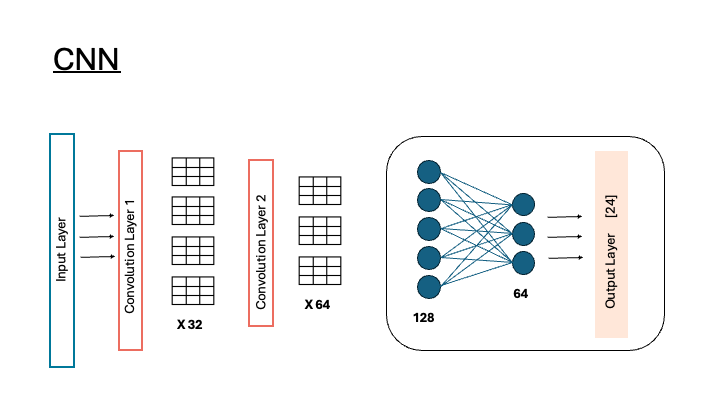

### Defining input layer using Keras

In [12]:
# Each sample is 28 by 28 image with 1 color channel, each batch size is not fixed
img_inputs = keras.Input(shape = (28, 28, 1))

In [13]:
# Checking shape of my_inputs
# None = placeholder for batch size
img_inputs.shape

TensorShape([None, 28, 28, 1])

In [14]:
# Checking dtype of my_inputs
img_inputs.dtype

tf.float32


### Creating my hidden layers

In [15]:
# Passing inputs and setting up hidden layer 'steps'
hidden_l1 = Conv2D(32, (3, 3), activation='relu', name='conv_layer_1')(img_inputs)
hidden_l1 = BatchNormalization()(hidden_l1)
hidden_l1 = MaxPooling2D((2, 2))(hidden_l1)
hidden_l1 = Dropout(0.25)(hidden_l1)


In [16]:
# Checking layer output
hidden_l1

<KerasTensor: shape=(None, 13, 13, 32) dtype=float32 (created by layer 'dropout')>

In [17]:
hidden_l2 = Conv2D(64, (3, 3), activation='relu', name='conv_layer_2')(hidden_l1)
hidden_l2 = BatchNormalization()(hidden_l2)
hidden_l2 = MaxPooling2D((2, 2))(hidden_l2)
hidden_l2 = Dropout(0.25)(hidden_l2)


In [18]:
# Checking layer output
hidden_l2

<KerasTensor: shape=(None, 5, 5, 64) dtype=float32 (created by layer 'dropout_1')>

### Creating output layer

In [19]:
num_classes = np.unique(y).shape[0]

In [20]:
# Flatten into 1d for dense layers
output_layer = layers.Dense(128, activation="relu")(Flatten()(hidden_l2))
output_layer = layers.Dense(64, activation="relu")(output_layer)
output_layer = layers.Dense(num_classes, activation="softmax")(output_layer)

In [21]:
output_layer

<KerasTensor: shape=(None, 24) dtype=float32 (created by layer 'dense_2')>

### Defining the model

In [22]:
# Defining my model
my_model = keras.Model(inputs=img_inputs, outputs = output_layer, name = 'my_sign_lang_model')

In [23]:
my_model.summary()

Model: "my_sign_lang_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv_layer_1 (Conv2D)       (None, 26, 26, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 26, 26, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 13, 13, 32)        0         
                                                                 
 conv_layer_2 (Conv2D)       (None, 11, 11, 64) 

### Plotting my CNN

In [24]:
# from keras.utils.vis_utils import plot_model
# plot_model(model=my_model, to_file ="my_first_model.png", show_shapes = True, dpi=300)

**Comment:**

plot_model no longer works - I believe this beacause of the tensorflow version I have installed on my environment, if i run this in google colab it works.

I tried to upgrade the tensorflow version on my environment but for some reason the latest version I can download is 2.12.1

## Training the CNN
---

### Compile the model

In [25]:
my_model.compile(loss = 'sparse_categorical_crossentropy',
                  optimizer = 'Adam',
                  metrics = ['accuracy'])

### Train the model


In [26]:
# Modify the X values to be between 0-1 instead of 0-255
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')

X_train /= 255
X_val /= 255
# Sanity Check
print(f'X_train range: {X_train.min()}-{X_train.max()}')

X_train range: 0.0-1.0


In [27]:
X_train.shape

(27701, 784)

In [28]:
# Define input image dimensions
img_rows, img_cols = 28, 28

# Reshape for Keras model types (input is a 4d array- (num_of_images, height, width, channels))
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1)

print(f'X_train shape: {X_train.shape}')
print(f'X_val shape: {X_val.shape}')

X_train shape: (27701, 28, 28, 1)
X_val shape: (6926, 28, 28, 1)


In [29]:
# Use an early stopping callback to stop training
# once we no longer have improvements in our validation loss
early_stop = EarlyStopping(monitor='val_loss',
                           patience=2,
                           mode='min',
                           verbose=1)

In [30]:
history = my_model.fit(X_train, y_train,
                        batch_size = 128,
                        epochs = 10,
                        verbose = 1,
                        validation_split = 0.2,
                        callbacks = [early_stop])

Epoch 1/10


2024-07-07 19:06:39.240398: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


174/174 [==============================] - 5s 25ms/step - loss: 0.9374 - accuracy: 0.7177 - val_loss: 4.7272 - val_accuracy: 0.0682
Epoch 2/10
174/174 [==============================] - 5s 29ms/step - loss: 0.0743 - accuracy: 0.9789 - val_loss: 5.8926 - val_accuracy: 0.0753
Epoch 3/10
174/174 [==============================] - 5s 28ms/step - loss: 0.0318 - accuracy: 0.9909 - val_loss: 1.0711 - val_accuracy: 0.6692
Epoch 4/10
174/174 [==============================] - 5s 28ms/step - loss: 0.0140 - accuracy: 0.9963 - val_loss: 0.0213 - val_accuracy: 0.9986
Epoch 5/10
174/174 [==============================] - 4s 23ms/step - loss: 0.0111 - accuracy: 0.9971 - val_loss: 0.0072 - val_accuracy: 0.9998
Epoch 6/10
174/174 [==============================] - 7s 40ms/step - loss: 0.0080 - accuracy: 0.9975 - val_loss: 0.0082 - val_accuracy: 0.9995
Epoch 7/10
174/174 [==============================] - 5s 30ms/step - loss: 0.0087 - accuracy: 0.9972 - val_loss: 7.0926e-04 - val_accuracy: 1.0000
Epoch 

### Assessing training and validation scores

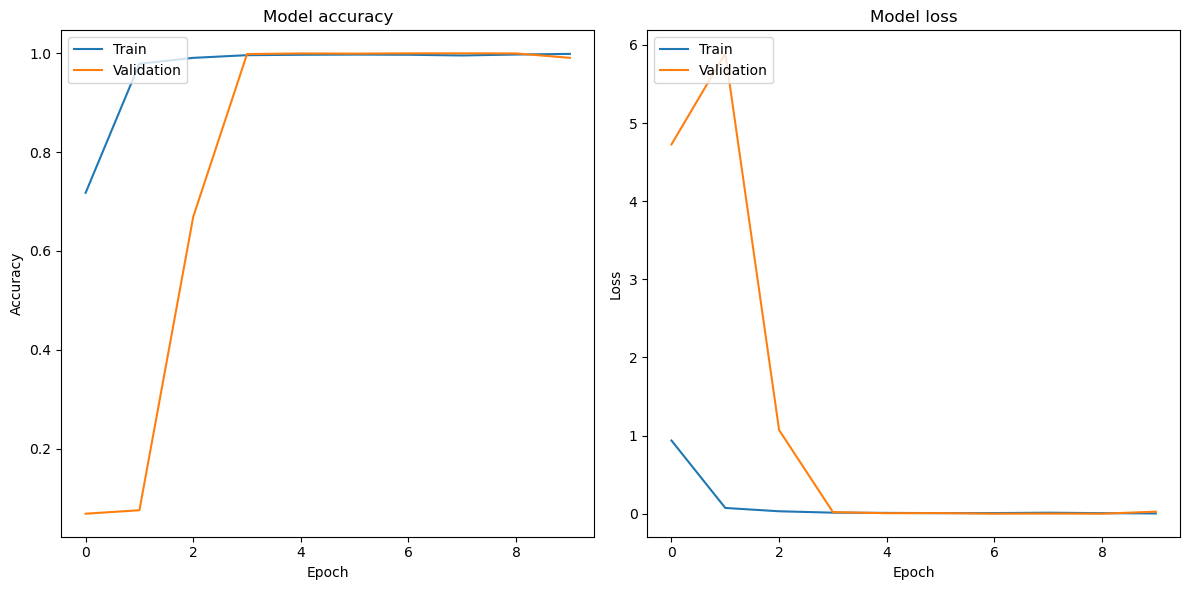

In [31]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 2
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


**Comment:**

As the number of epochs increases, the CNN begins to converge to more optimal weights(kernels) resulting in improved accuravy and lower loss.

In [32]:
# Evaluate the model's performance on the test data
score = my_model.evaluate(X_train, y_train, verbose=1)

866/866 [==============================] - 2s 3ms/step - loss: 0.0222 - accuracy: 0.9930


In [33]:
print(f'CNN model Training Score: {round(score[1]*100,4)}')

CNN model Training Score: 99.2961


In [34]:
# Evaluate the model's performance on the test data
score = my_model.evaluate(X_val, y_val, verbose=1)

217/217 [==============================] - 1s 3ms/step - loss: 0.0248 - accuracy: 0.9926


In [35]:
print(f'CNN model Validation Score: {round(score[1]*100,4)}')

CNN model Validation Score: 99.2636


### Saving the model

In [36]:
my_model.save('../../model/my_models/CNN_model.h5')

## Model Interpretability
----

In [37]:
CNN_model = load_model('../../model/my_models/CNN_model.h5')

In [38]:
# getting name of conv2d layers - to feed into functions below
for layer in CNN_model.layers:
    if isinstance(layer,Conv2D):
        print(layer.name)

conv_layer_1
conv_layer_2


### Inspect weights (kernels)

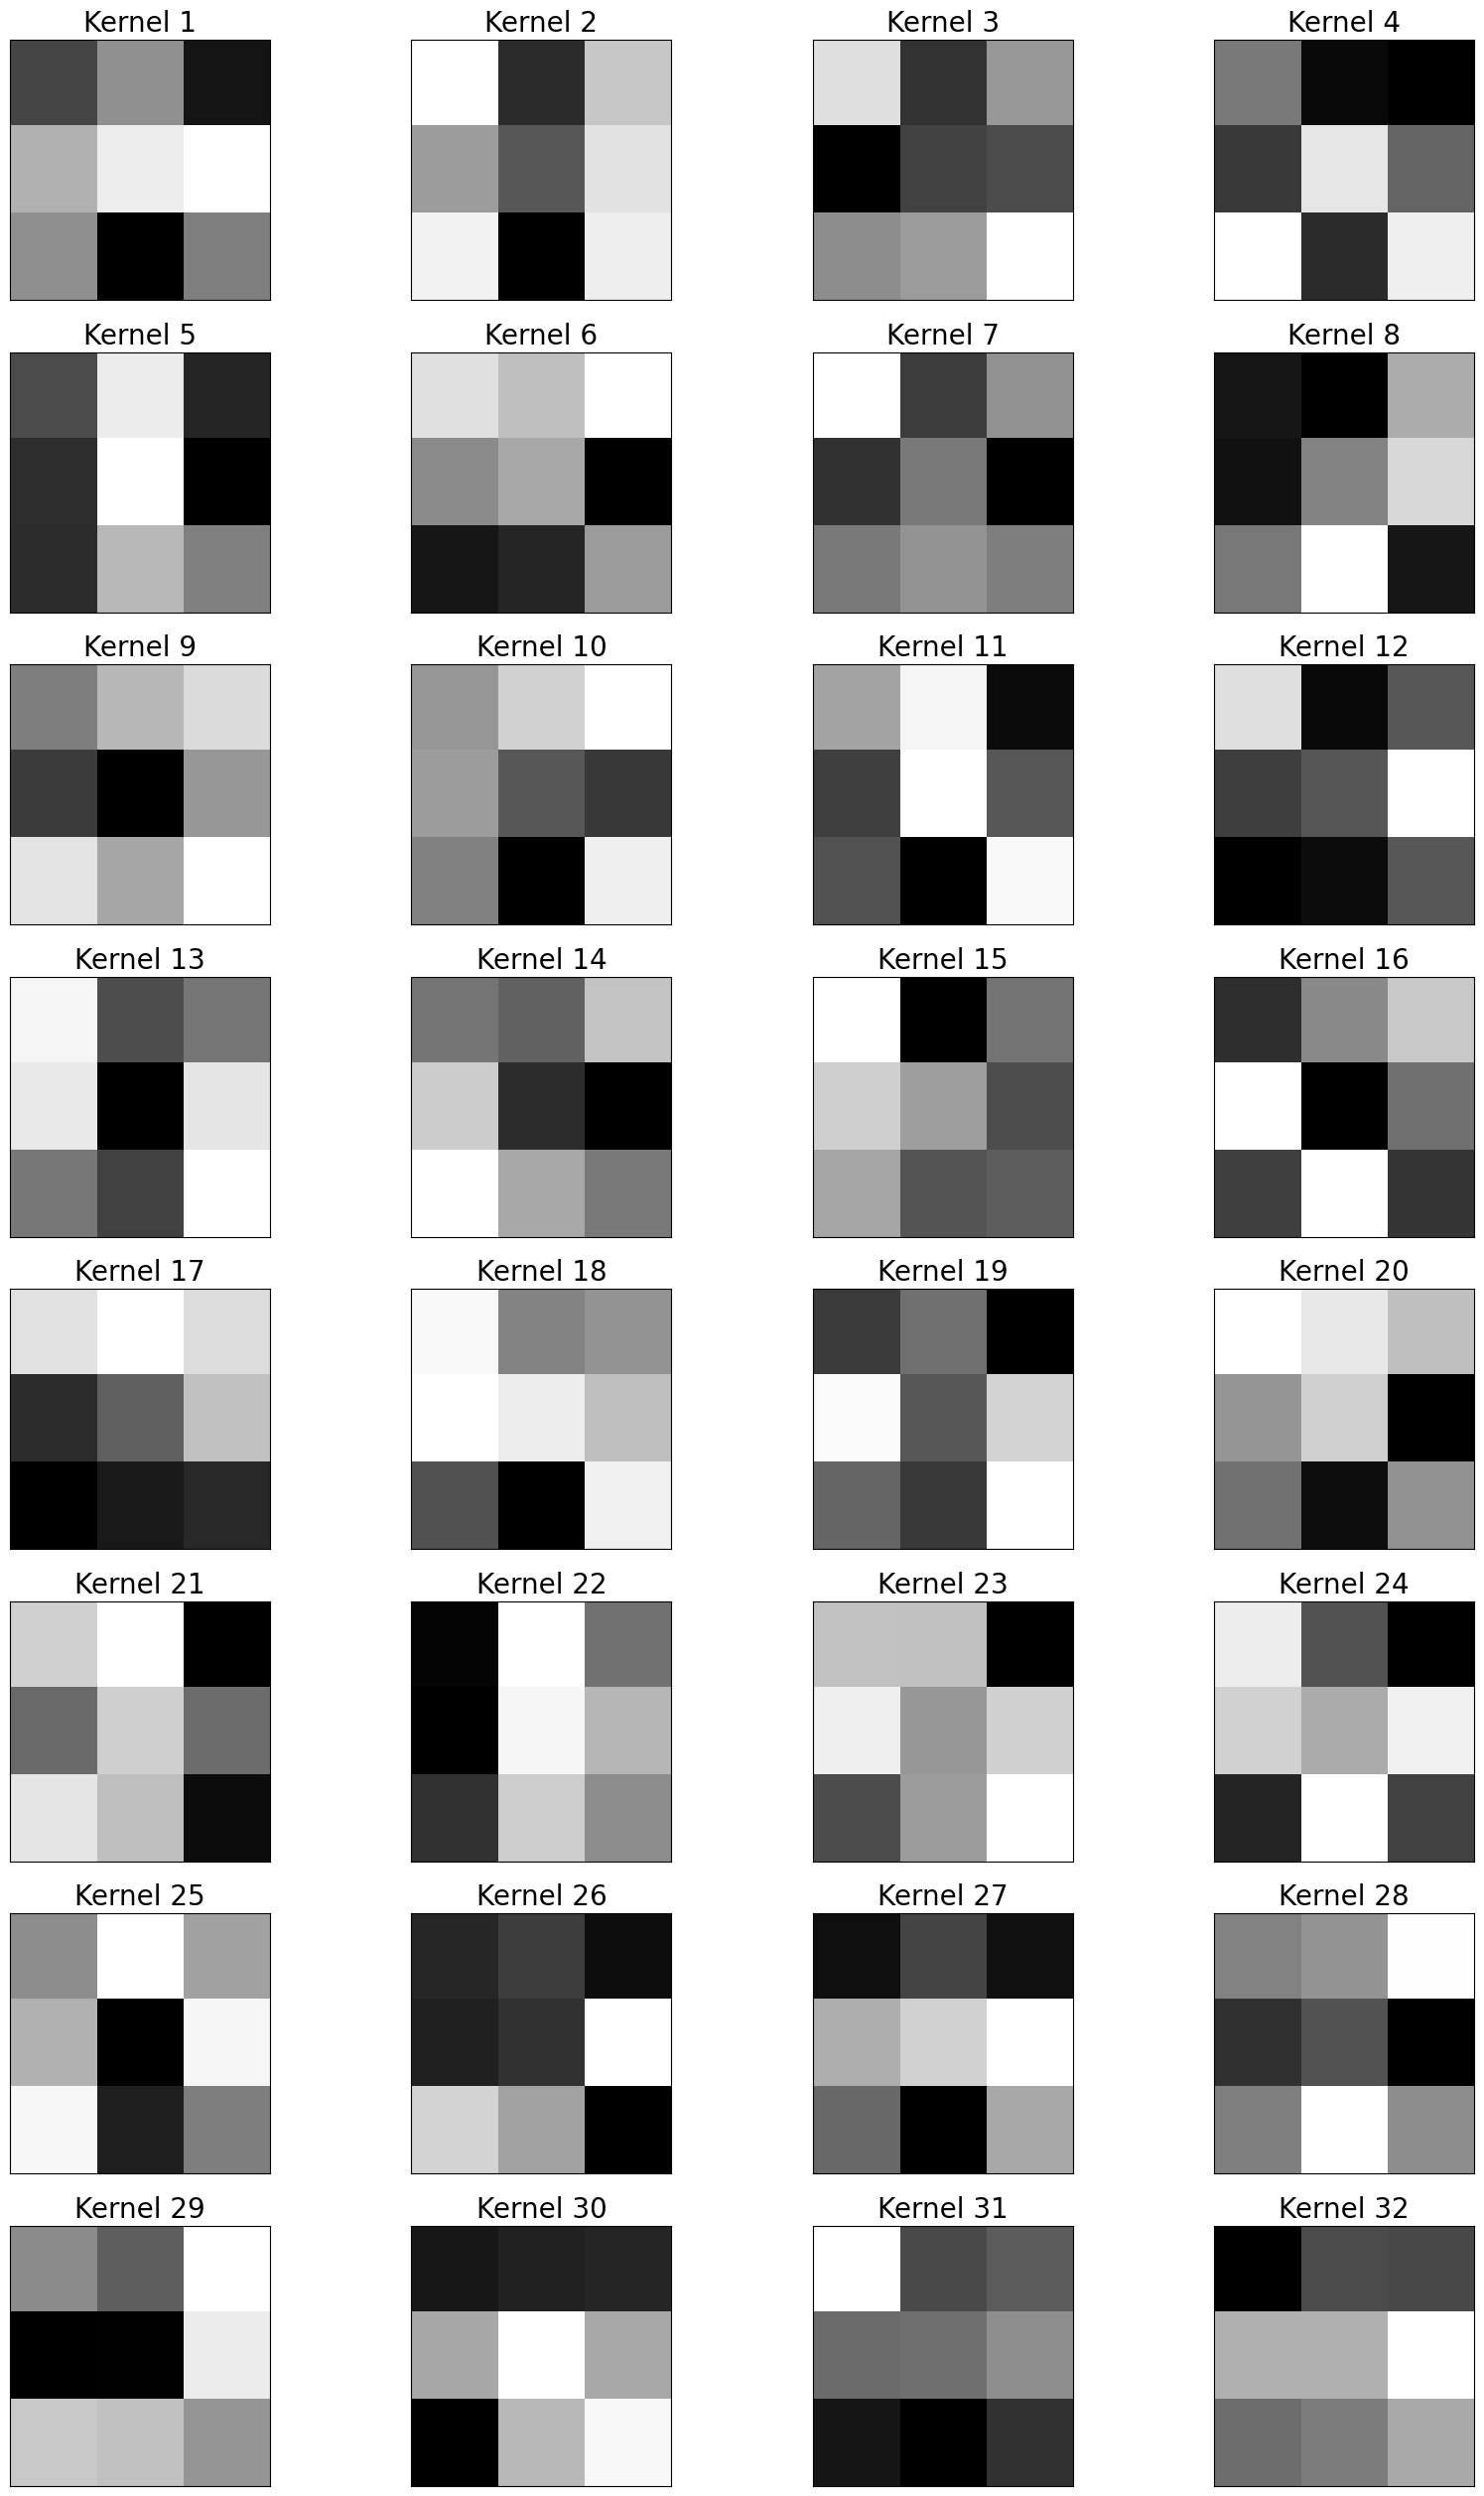

In [39]:
inspect_weights(CNN_model,layer_name='conv_layer_1')

**Plot Description:**

This plot shows us the weights for each kernel in the first convolutional layer. Darker regoins signify larger weights suggesting these regions represent patterns which the filter is searching for in the input image.

Further down in the notebook, I show the input image against the filter and output of the image after filter convolution. This will allow for a deeper analysis as to what each filter is trying to detect.

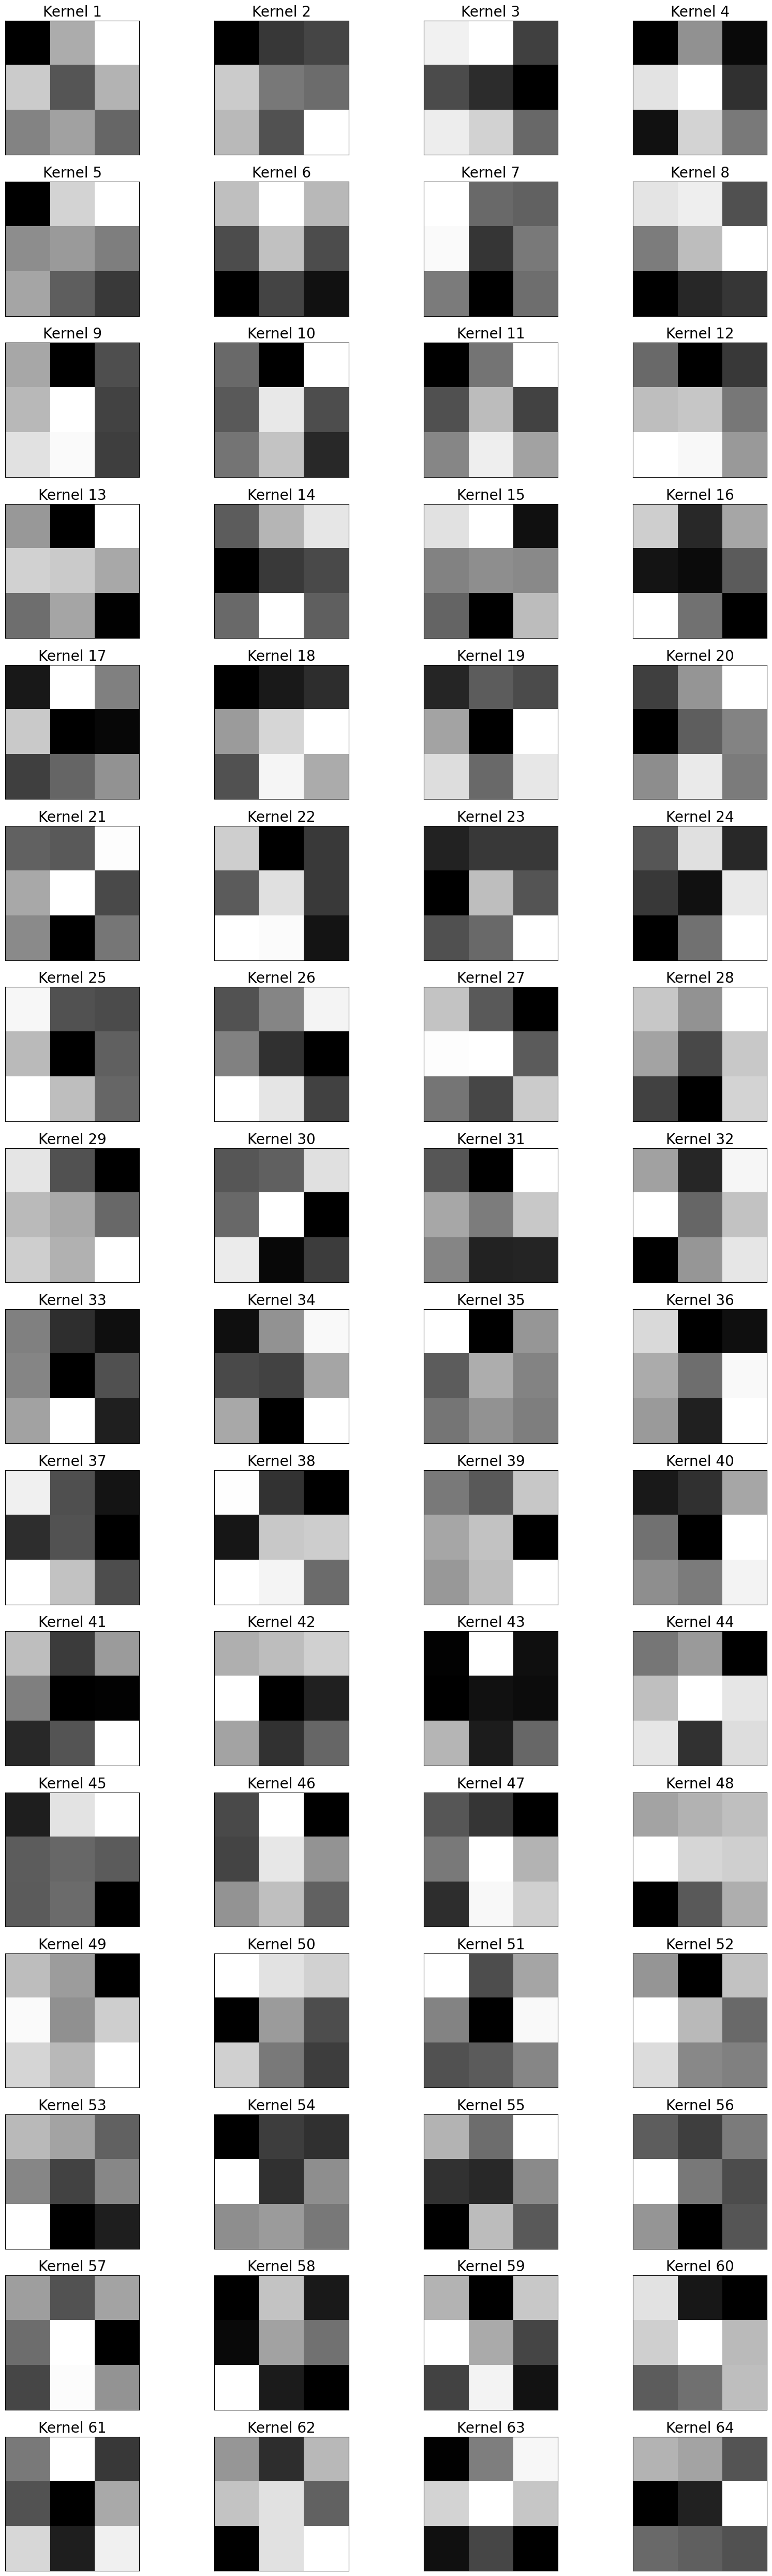

In [40]:
inspect_weights(CNN_model,layer_name='conv_layer_2')

**Plot Description:**

This plot shows us the weights for each kernel in the second convolutional layer. As stated above, darker regoins signify larger weights suggesting these regions represent patterns which the filter is searching for in the input image.

Filters in the second layer are looking for more complex patterns in comparison to first layer filters and so are harder to visualise. Filters in the second layer convolve over the output of the first layer which futher adds to the complexity in interpreting patterns.

### Inspecting feature maps

1/1 [==============================] - 0s 63ms/step


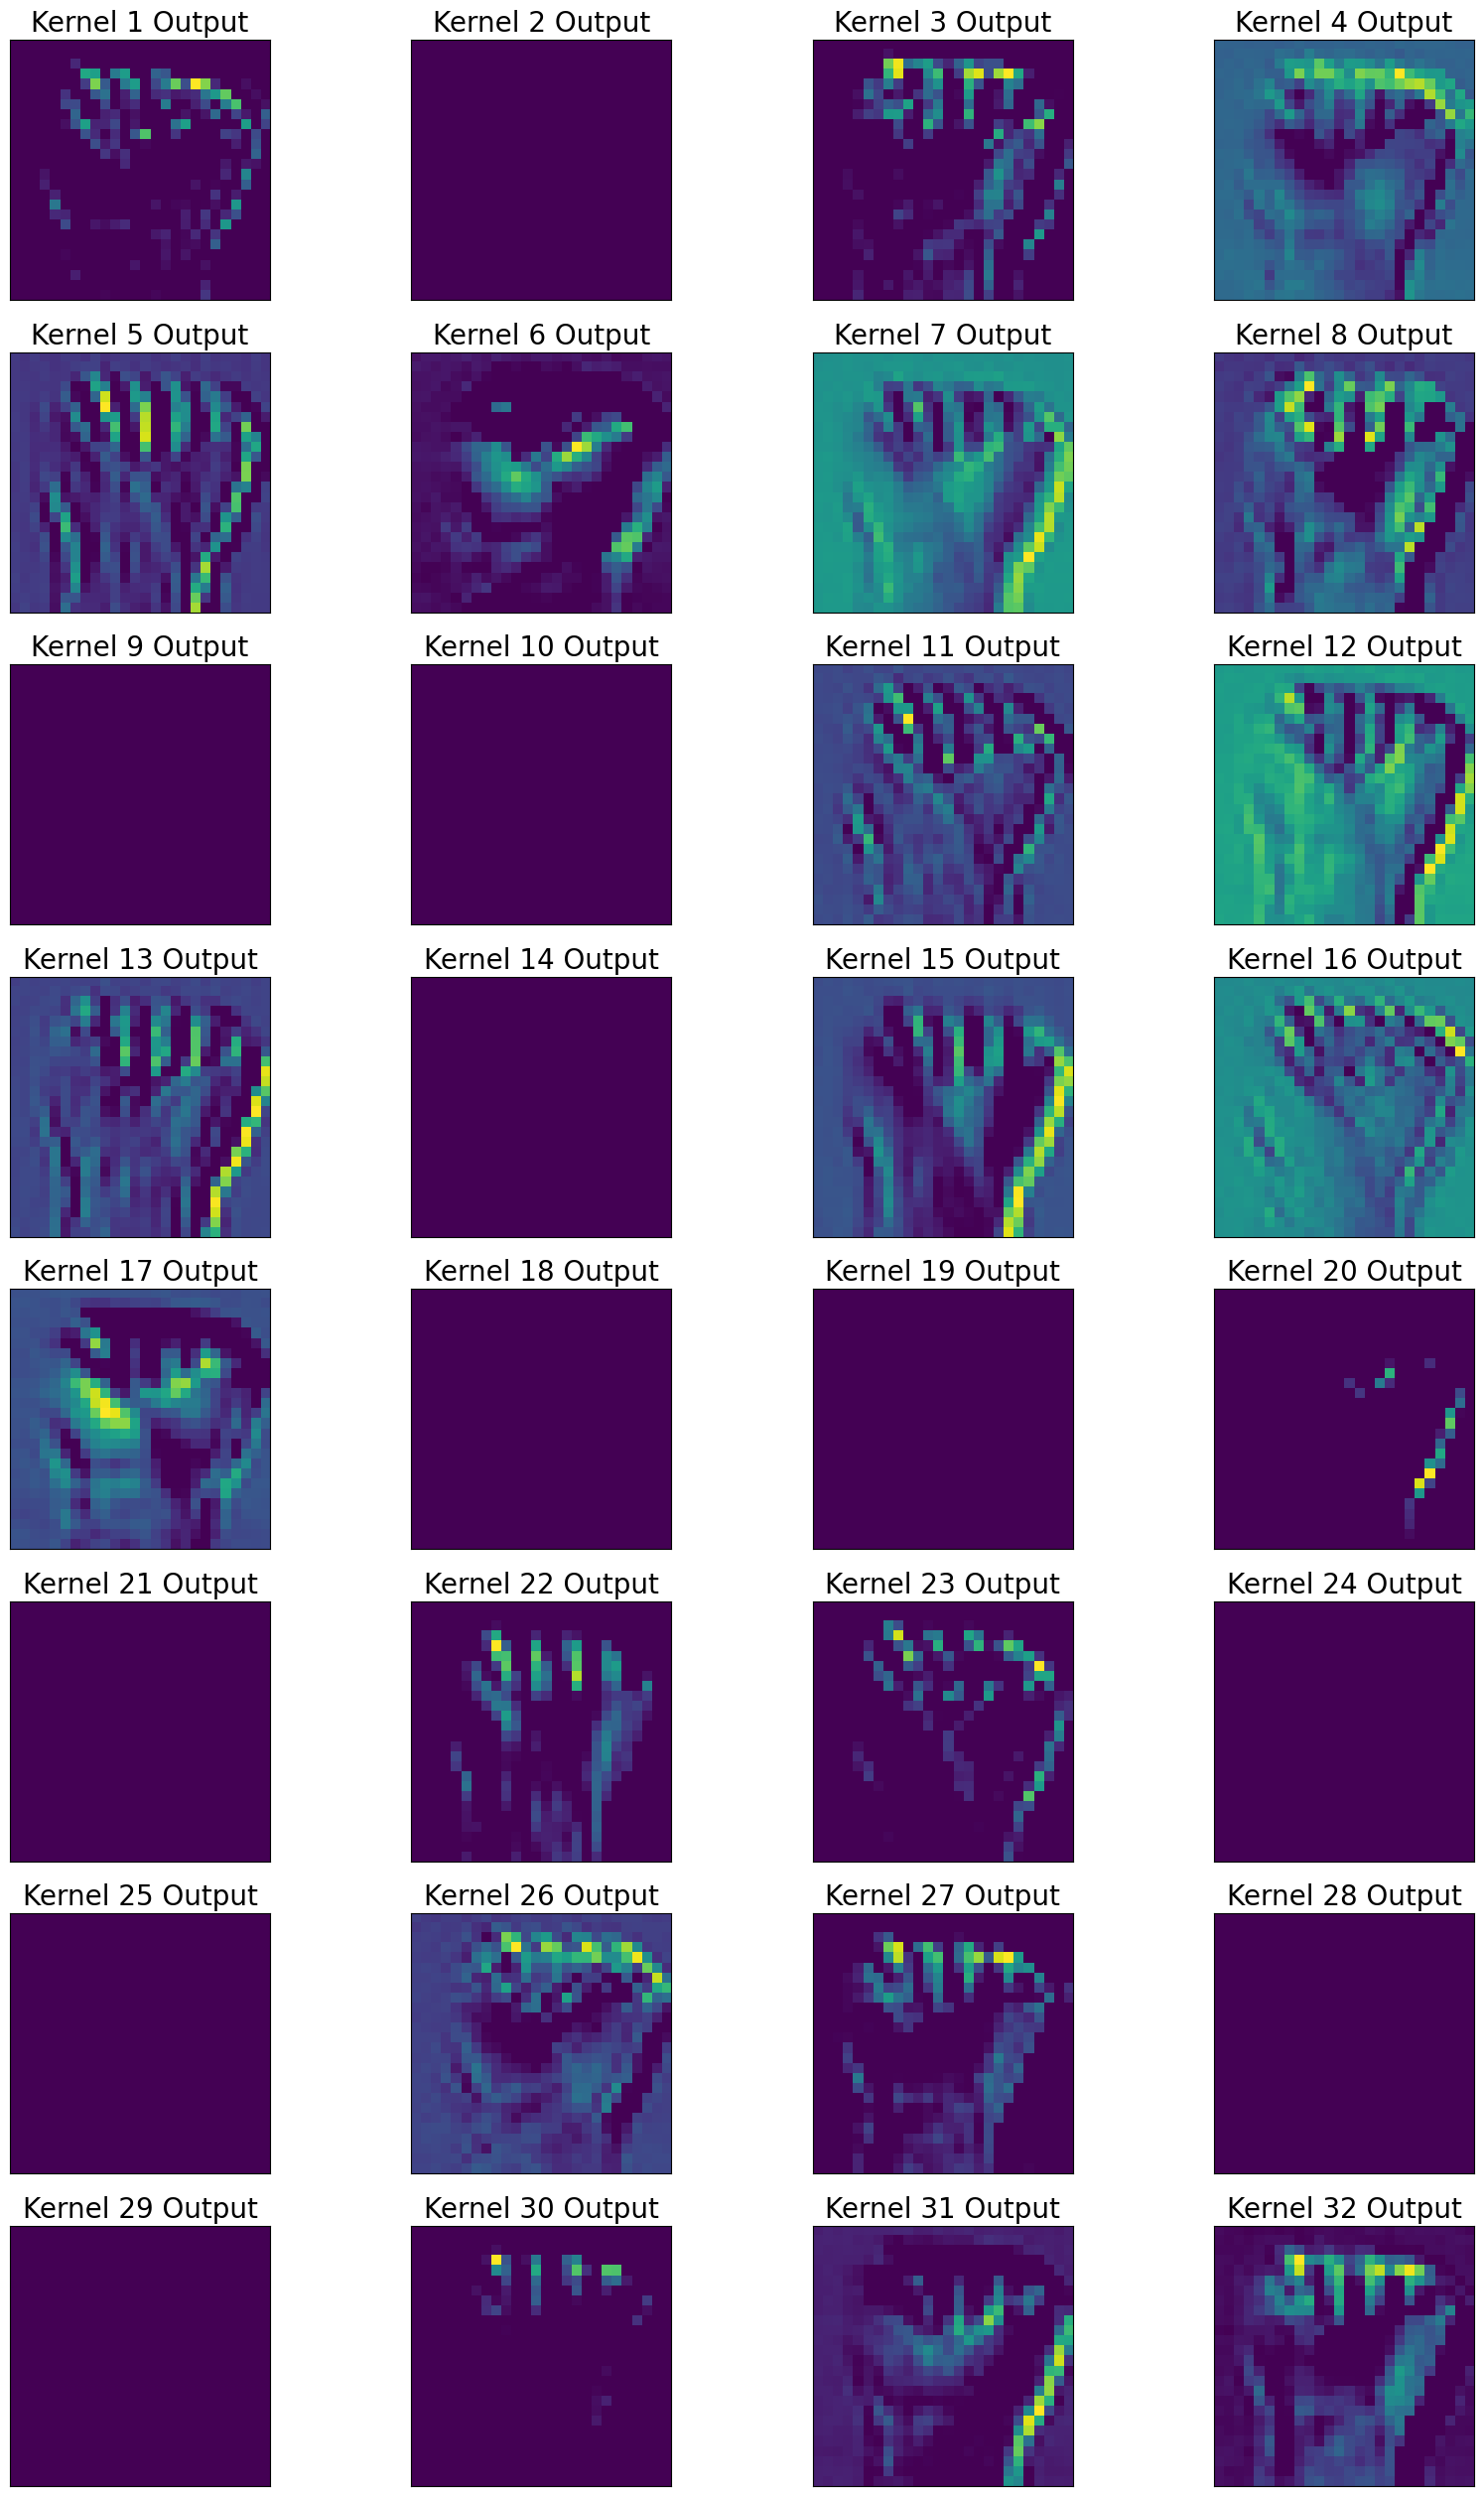

In [41]:
# getting feature maps from first conv layer for letter A
get_conv_layer_ouput(model = CNN_model, layer_name = 'conv_layer_1', input_img = get_letter_img(X_data=X, letter='A'))

**Plot Description:**

The feature maps show the resulting image after convolution has occured. In the first convolution layer there are 32 different kernels applied to the input image. 

First layer kernels captures low-level patterns such as edges and corners. The output above shows the different fetaurte maps after each kernel convolved over the input image. 

Lighter regions indicate areas where the kernel has detected relevant features according to its learned weights. 

Darker regoins indicatge areas the features between filter and the image are less similar.This provides us this with a better understanding of the result of the first convolution.

1/1 [==============================] - 0s 33ms/step


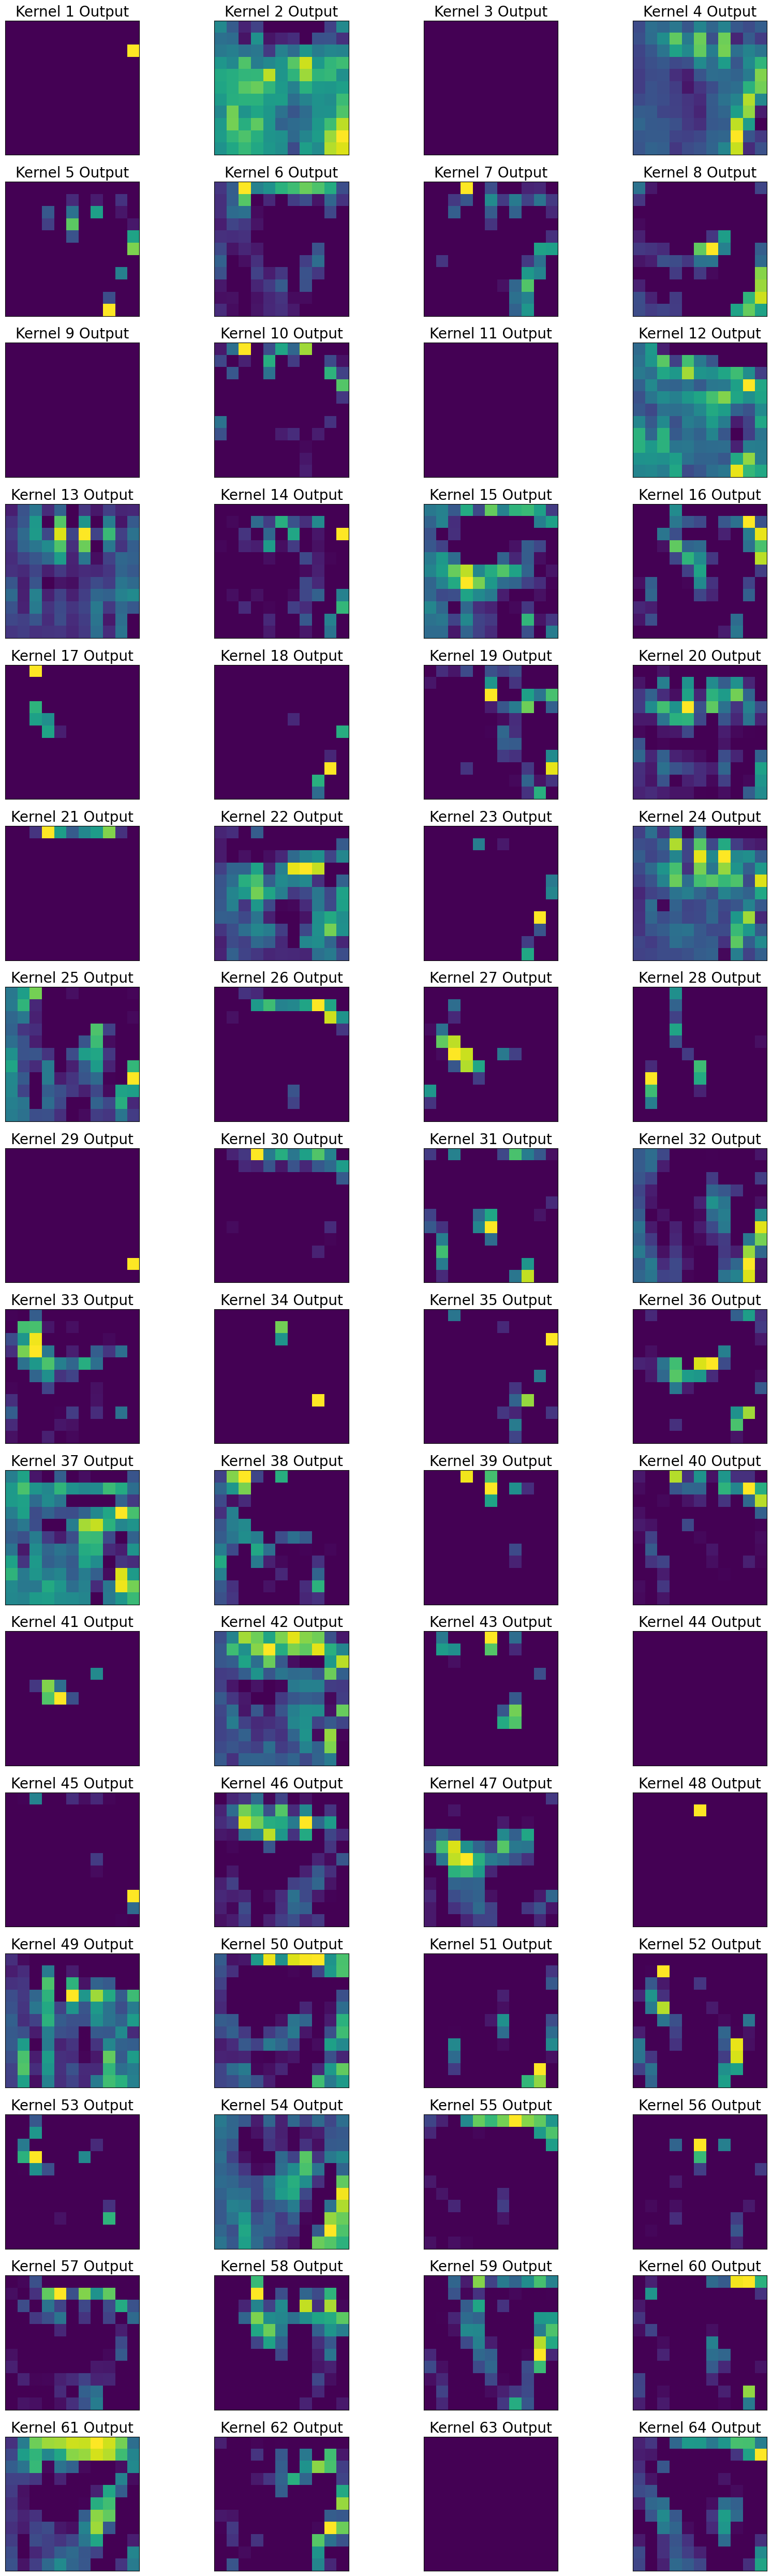

In [42]:
# getting feature maps from second conv layer for letter A
get_conv_layer_ouput(model = CNN_model,layer_name = 'conv_layer_2', input_img = get_letter_img(X,'a') )

**Plot Description:**

In the second convolution layer there are 64 different kernels applied.
 
Second layer kernels are used to capture higher level patterns such as combinations of edges or textures as the kernels convolve over the feature map of the previous convolution layer.

Again, the lighter regions indicate areas where the kernel has detected relevant features for its given weights. This provides us this with a better understanding of the result of the second convolution.

Note, the as the convolution layers increase the feature maps become harder to interpret due to the complexity of combining previously "learnt" features.

### Comparison of input image and feature map for a specific layer and kernel

1/1 [==============================] - 0s 23ms/step


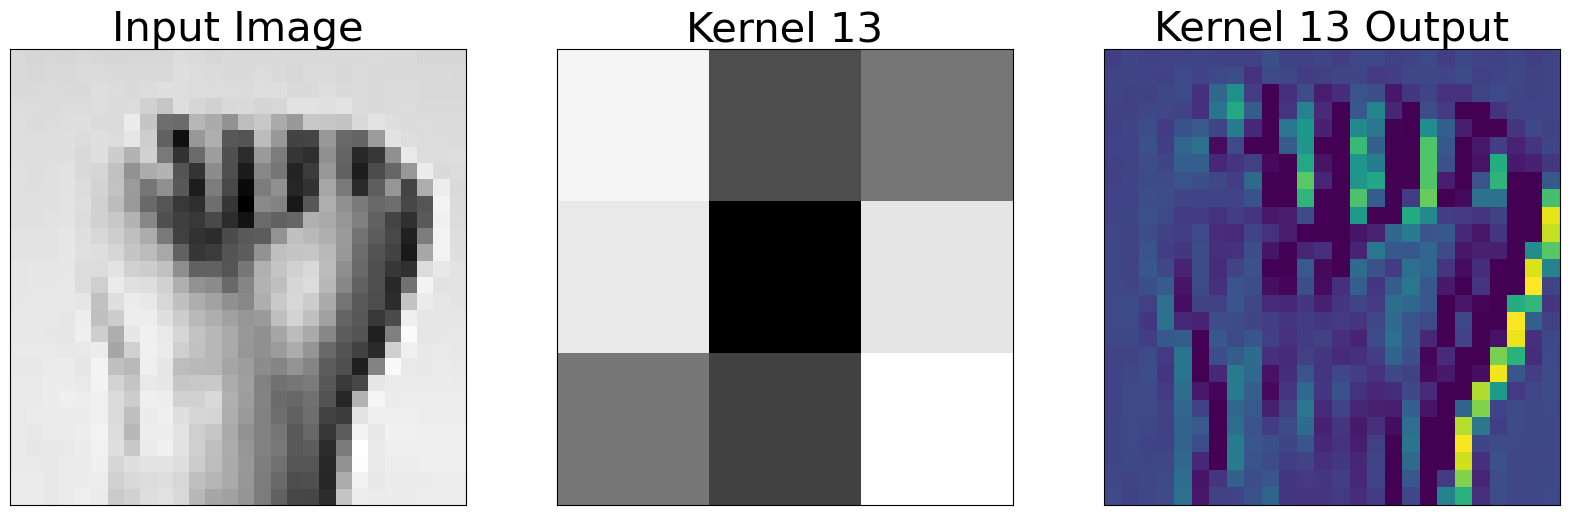

In [56]:
kernel_with_output(model = CNN_model,input_image = get_letter_img(X_data=X,letter='a'), layer_name = 'conv_layer_1', kernel=13)

**Comment:**

From looking at kernel 14 weights, we can see that the kerenl has found patterns in the curled fingers of the hand as well as the edge.This kernel could be important for the model in distinguishing between open and closed hand signs.

1/1 [==============================] - 0s 27ms/step


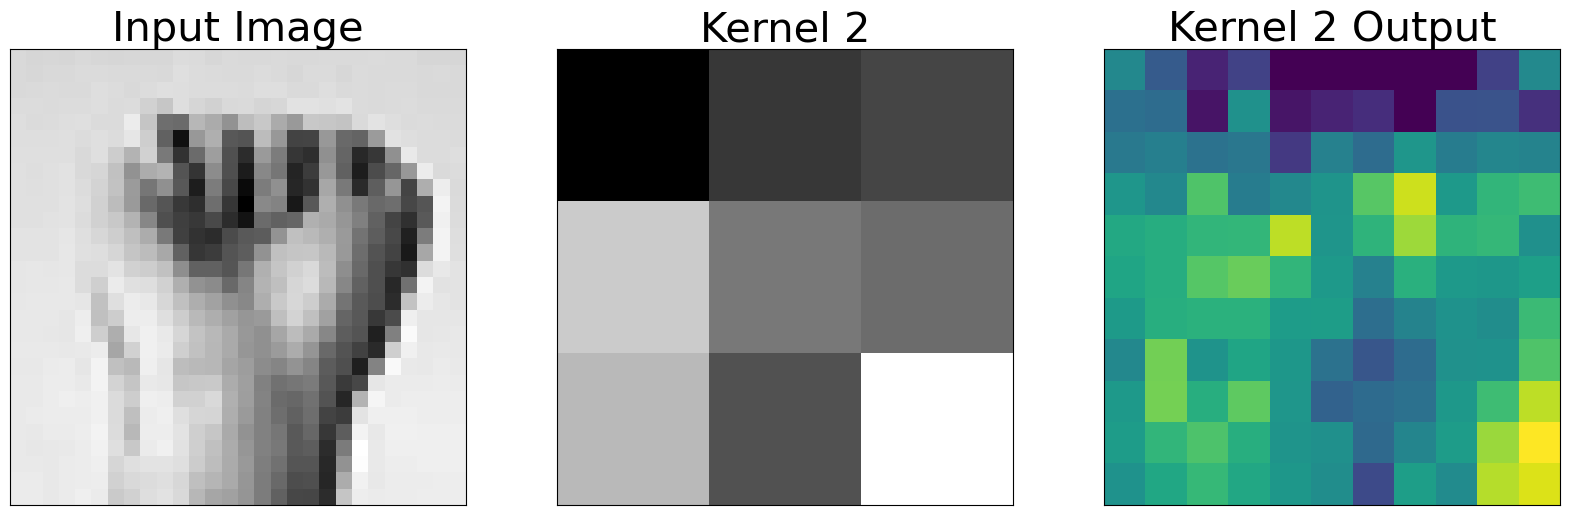

In [44]:
kernel_with_output(model = CNN_model,input_image = get_letter_img(X,'a'), layer_name = 'conv_layer_2', kernel=2)

**Comment:**

Here we can see the second layer kernels are harder to interpret when compared to the input image. The reason for this is that these kernels are applied to the output of the previous convolution layer. 

Kernels in the second layer have learnt to detect more abstract patterns often from combining the output of the previous convolutional layer. The deeper the convolutional layers get, the more abstract and complex the features become making it more challenging in terms of interpretability. 

## Model Evaluation
---

In [45]:
CNN_model = load_model('../../model/my_models/CNN_model.h5')

In [46]:
score = CNN_model.evaluate(X_val, y_val, verbose=1)
print(f'CNN model Validation Score: {round(score[1] * 100,4)}')

217/217 [==============================] - 1s 3ms/step - loss: 0.0248 - accuracy: 0.9926
CNN model Validation Score: 99.2636


### Confusion Matrix

217/217 [==============================] - 1s 3ms/step


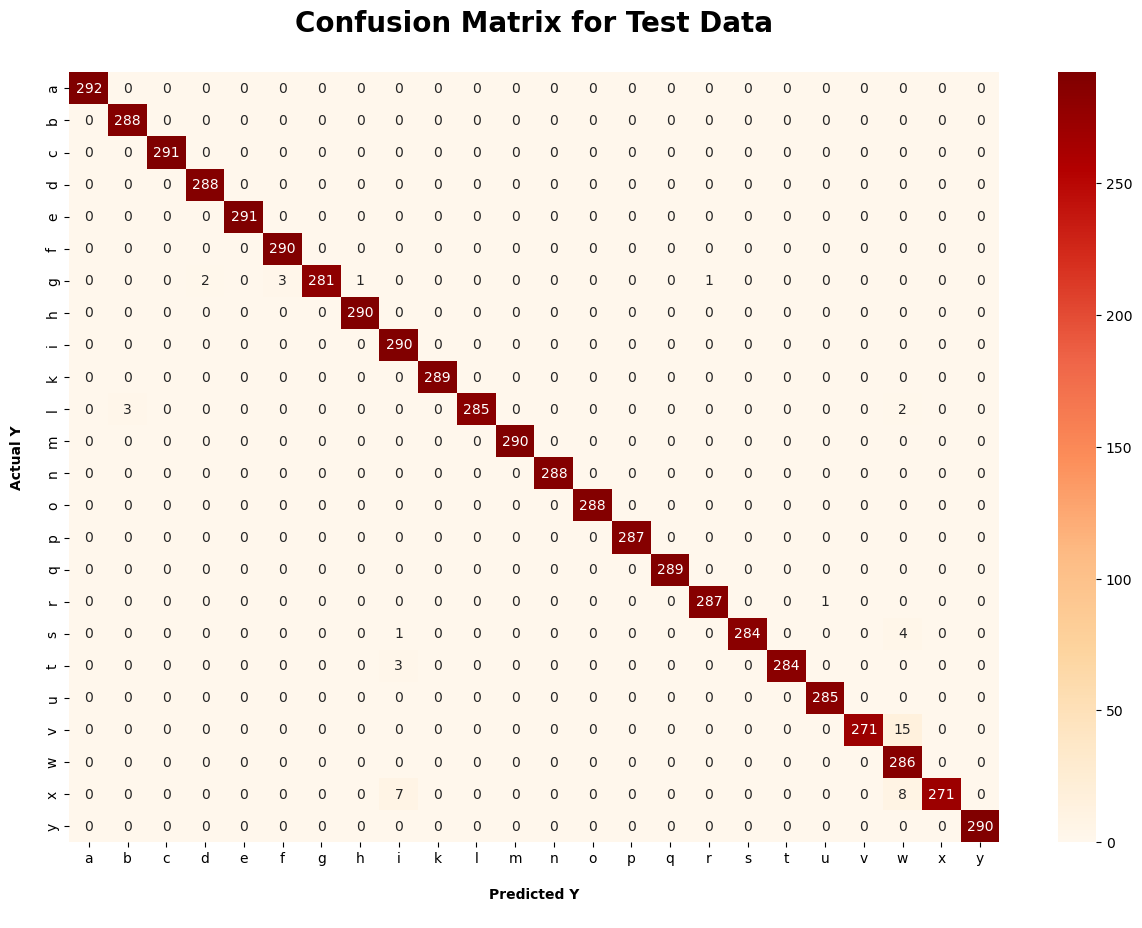

In [47]:
from sklearn.metrics import confusion_matrix

# Calculate the predicted labels for each test image.
soft_pred = CNN_model.predict(X_val)
pred_y = np.argmax(soft_pred, axis=1)

# Create the confusion matrix using sklearn
conf_mat = confusion_matrix(y_val, pred_y)

plt.figure(figsize=(15, 10))
sns.heatmap(conf_mat,
            annot=True,
            fmt = 'd',
            cmap="OrRd",
           )
plt.title('Confusion Matrix for Test Data\n', fontsize=20, fontweight = 'bold')
plt.xlabel('\nPredicted Y\n', fontsize=10,fontweight = 'bold')
plt.ylabel('Actual Y\n',fontsize=10, fontweight = 'bold')
plt.xticks([x + 0.5 for x in range(len(unique_values))], alphabet)
plt.yticks([y + 0.5 for y in range(len(unique_values))], alphabet)
plt.show()

### Visualising misclassifications

In [48]:
# check X_val = correct shape
# if not 4d => X_val = X_val.reshape(X_val.shape[0], 28, 28, 1)
X_val.shape

(6926, 28, 28, 1)

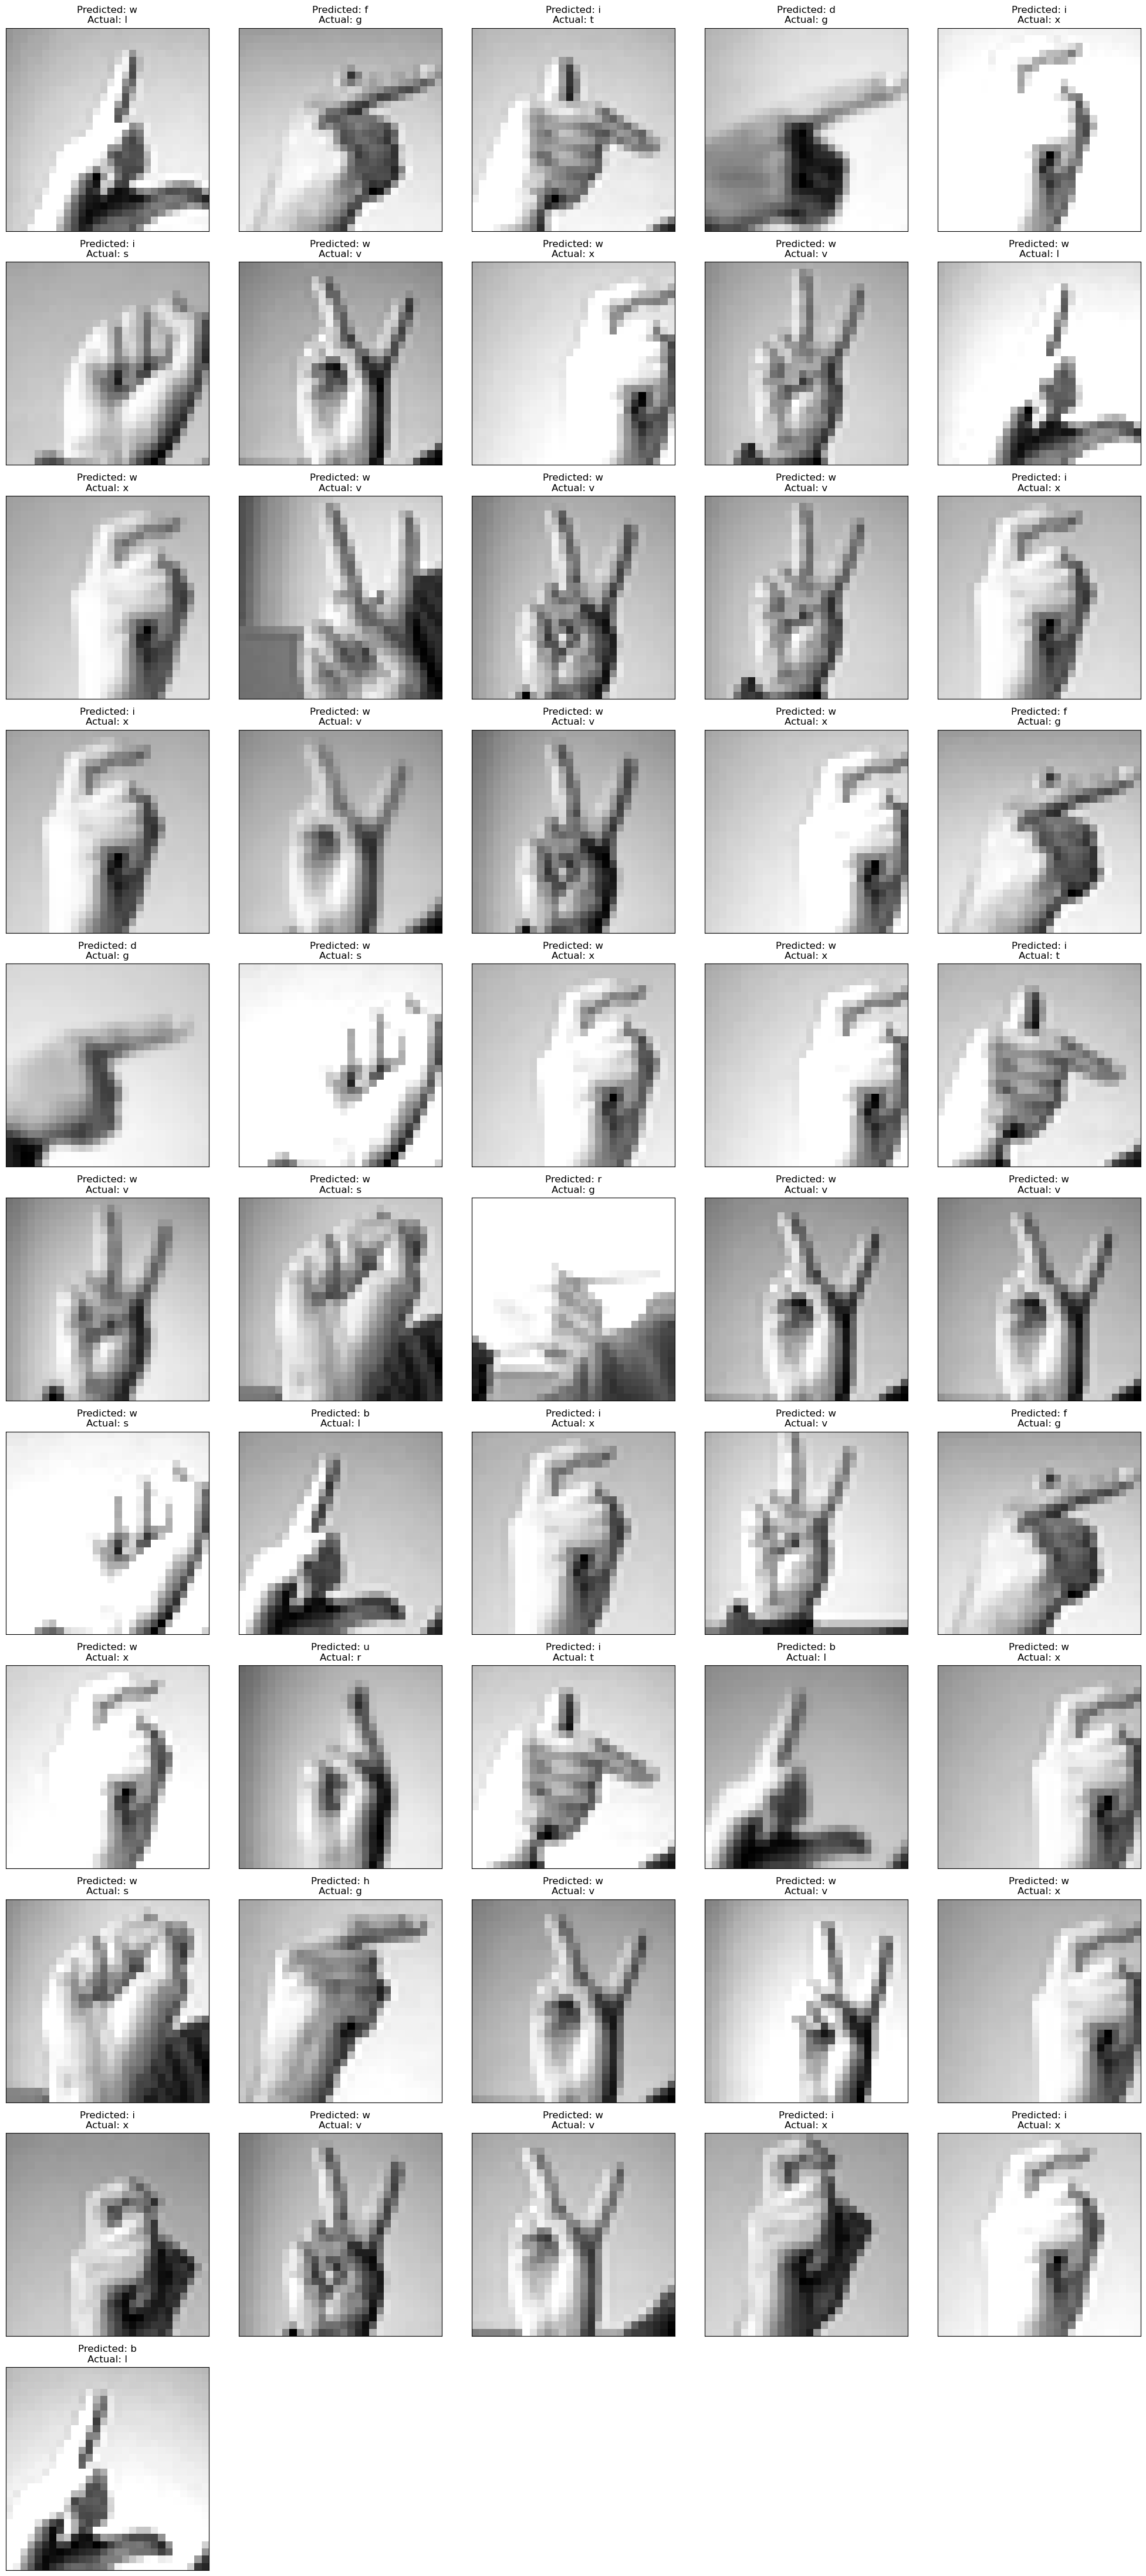

In [49]:
incorrect_photos = (y_val != pred_y)
num_photos = incorrect_photos.sum()
rows = math.ceil(num_photos / 5)

fig, axes = plt.subplots(rows, 5, figsize=(20, 4 * rows))

for i, ax in enumerate(axes.flatten()):
    if i < num_photos:
        ax.imshow(X_val[incorrect_photos][i], cmap='gray')

        # Get predicted label
        p = pred_y[incorrect_photos][i]
        prediction = alphabet[p]

        # Get actual label
        a = y_val[incorrect_photos][i]
        actual = alphabet[a.astype(np.int32)]

        # Set the title of the subplot
        ax.set_title(f"Predicted: {prediction}\nActual: {actual}")

        # Hide the x and y ticks
        ax.set_xticks([])
        ax.set_yticks([])
    else:
        fig.delaxes(ax)  # Delete unused subplots

plt.tight_layout()
plt.show()

**Comment:**

Misclassifications seem to be when there is augmenations so the hands are no longer centered or are cropped out of the image and when the lighting is poor (too bright). Such conditions make it harder for the model to classify letters correclty.



### Testing an Unseen Input Image

In [50]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# loading a test image for ASL sign 'C'
image_path = '../../data/my_imgs/C.JPG'
input_image = load_img(image_path, target_size=(28, 28))
# Convert image to greyscale
input_image = input_image.convert('L')
# Rotating image to have correct orientation (see below)
input_image = input_image.rotate(270)

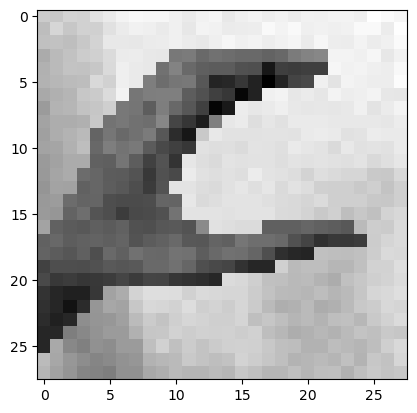

In [51]:
plt.imshow(input_image,cmap='gray') # checking image has correct orientation
plt.show()

In [52]:
# Convert the image to a NumPy array
image_array = img_to_array(input_image)

In [53]:
# Reshaping to have dimesntions (1,28,28,1) -> to match X_train/X_test dimensions
# 1 as only single image is uploaded
test_img = image_array.reshape(1, image_array.shape[0], image_array.shape[1], image_array.shape[2])

In [54]:
soft_pred = CNN_model.predict(test_img)
pred_y = np.argmax(soft_pred, axis=1)

1/1 [==============================] - 0s 12ms/step


In [55]:
print(f'Prediction using CNN: \n{alphabet[pred_y[0]].upper()}')

Prediction using CNN: 
C


## Conclusion
----

|                  | CNN        |
|------------------|------------|
| Train Score      | 99.30      |
| Validation Score | 99.26      |

Performance of the CNN model is relatively high on the MNIST dataset.

The reason I have decided to progress to using a CNN network is that we have already seen the benefits of feature extraction and how doing this leads to a more robust model.

CNNs also perform feature extraction but they do this automatically without the need of manual creation (like we did in 02-log-reg-feature-extraction.ipynb). By automatically learning features, the CNN is able to discover patterns relevant to the data that we could not manually create using HOG/LBP methods. 

In addition to this, CNNs are able to generalise better to unseen images compared to logistic regression models. The kernels act as shared weights which allows the CNN to detect the same features in any image even if the image is augmented to a certain degree. In the next notebook we will investiagate the perfomance of the CNN model with data augmentation. 

